In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("combined.csv")
data = data.drop("date.1", axis=1)
data = data.drop("date", axis=1)
data

,temperature,rain,wind_speed,wind_direction,humidity,pressure,total_cloud,visibility,solar_radiation
0,4.2,0.0,2.1,320.0,68.0,1021.5,0.0,20000.0,0.0
1,4.1,0.0,1.9,320.0,67.0,1021.4,0.0,20000.0,0.0
2,3.9,0.0,1.0,250.0,68.0,1021.7,0.0,20000.0,0.0
3,3.7,0.0,1.9,320.0,70.0,1021.6,0.0,20000.0,0.0
4,3.6,0.0,1.1,50.0,72.0,1020.7,0.0,17950.0,0.0
...,...,...,...,...,...,...,...,...,...
59562,18.7,0.0,1.8,180.0,72.0,15.5,2.0,4057.0,0.0
59563,16.4,0.0,0.7,200.0,84.0,15.6,3.0,3245.0,0.0
59564,14.4,0.0,0.5,70.0,88.0,14.4,6.0,2590.0,0.0
59565,13.0,0.0,0.1,0.0,92.0,13.7,5.0,1632.0,0.0


In [3]:
# data["date"] = pd.to_datetime(data["date"])
# data = data.set_index("date")
# data

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

datax1 = scaler.fit_transform(data[["total_cloud", "rain", "visibility", "humidity"]])
datax2 = scaler.fit_transform(data[["total_cloud", "rain", "visibility", "humidity", "wind_speed", "wind_direction", "pressure", "temperature"]])
datay = scaler.fit_transform(data["solar_radiation"].to_numpy().reshape(-1, 1))

In [9]:
# Train
time_steps = 48
features = 4

feature_array = datax1
dv_array = datay
feature_array.shape
dv_array.shape

(59567, 1)

In [10]:

# array = data["solar_radiation"].to_numpy()

num_sequence = len(feature_array) - time_steps

X1 = np.zeros((num_sequence, time_steps, features))
y1 = np.zeros(num_sequence)

for i in range(num_sequence):
    X1[i] = feature_array[i: i+time_steps]
    y1[i] = dv_array[i + time_steps]


/var/folders/td/8pk_dg054tl5dgjkt99r7wf80000gn/T/ipykernel_200/3162236423.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1[i] = dv_array[i + time_steps]


In [11]:
train_size =round(len(X1) * 0.7)

trainX = X1[:train_size]
trainy = y1[:train_size]

testX = X1[train_size:]
testy = y1[train_size:]


In [12]:
optimizer = Adam(learning_rate=0.0001)

model1 = Sequential()

model1.add(Input((48,4)))
model1.add(LSTM(10, activation="relu"))
model1.add(Dense(1))

model1.compile(loss="mse", optimizer=optimizer)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                600       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 611 (2.39 KB)
Trainable params: 611 (2.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.1720 - val_loss: 0.0964
Epoch 2/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0657 - val_loss: 0.0587
Epoch 3/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0500 - val_loss: 0.0558
Epoch 4/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0487 - val_loss: 0.0545
Epoch 5/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0478 - val_loss: 0.0529
Epoch 6/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0470 - val_loss: 0.0508
Epoch 7/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0462 - val_loss: 0.0488
Epoch 8/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0453 - val_loss: 0.0463
Epoch 9/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.0441 - val_loss: 0.0407
Epoch 10/3000
521/521 [==============================] - 3s 5ms/step - loss: 0.042

<Axes: >

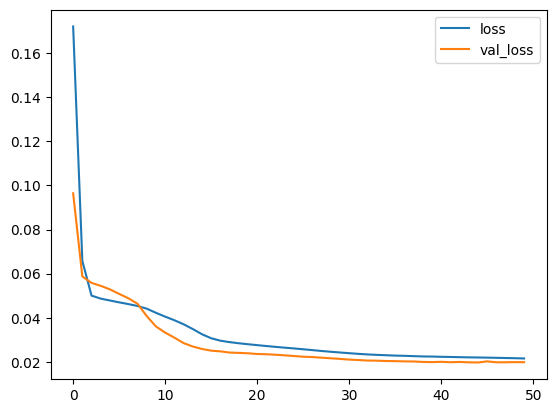

In [13]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=5, mode="auto")
trained = model1.fit(trainX, trainy, validation_split=0.2, batch_size=64, epochs=3000, callbacks = [early_stopping])
pd.DataFrame.from_dict(trained.history).plot()

In [14]:
loss = model1.evaluate(testX, testy)
print(f"Test loss: {loss}")

558/558 [==============================] - 1s 1ms/step - loss: 0.0199
Test loss: 0.01990416832268238


In [15]:
predicted1 = model1.predict(testX)
predicted1

558/558 [==============================] - 1s 1ms/step


array([[-0.08604129],
       [-0.07613028],
       [-0.05098636],
       ...,
       [-0.15812665],
       [-0.1633645 ],
       [-0.15657339]], dtype=float32)

In [16]:
predicted1 = np.maximum(0, predicted1)
predicted1

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

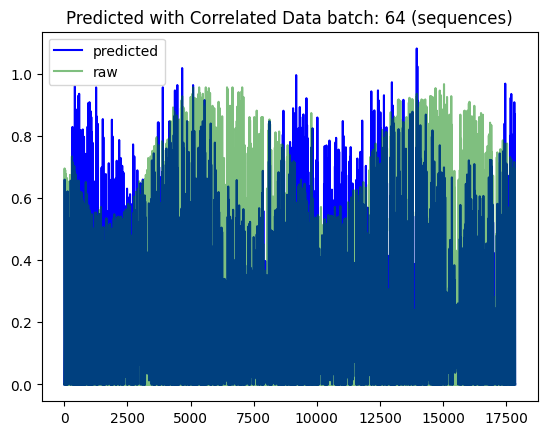

In [17]:
import matplotlib.pyplot as plt

plt.title("Predicted with Correlated Data batch: 64 (sequences)")
plt.plot(  predicted1, c="b", label="predicted")
plt.plot( testy,c="g", alpha=.5, label="raw")
plt.legend(loc="best")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error


In [19]:
predicted1.shape

(17856, 1)

In [20]:
error = mean_squared_error(testy, predicted1)

print("MSE: {}, RMSE: {}".format(error, np.sqrt(error)))

MSE: 0.018857703583226193, RMSE: 0.13732335410710805


In [21]:
feature_array2 = datax2
dv_array2 = datay


In [22]:
time_steps = 48
features2 = 8

num_sequence2 = len(feature_array2) - time_steps

X2 = np.zeros((num_sequence2, time_steps, features2))
y2 = np.zeros(num_sequence2)

for i in range(num_sequence2):
    X2[i] = feature_array2[i: i+time_steps]
    y2[i] = dv_array2[i + time_steps]

/var/folders/td/8pk_dg054tl5dgjkt99r7wf80000gn/T/ipykernel_200/3088642358.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2[i] = dv_array2[i + time_steps]


In [23]:
train_size =round(len(X2) * 0.7)

trainX2 = X2[:train_size]
trainy2 = y2[:train_size]

testX2 = X2[train_size:]

testy2 = y2[train_size:]

In [24]:
optimizer = Adam(learning_rate=0.0001)

model2 = Sequential()

model2.add(Input((48,8)))
model2.add(LSTM(10, activation="relu"))
model2.add(Dense(1))

model2.compile(loss="mse", optimizer=optimizer)

model2.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                760       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 771 (3.01 KB)
Trainable params: 771 (3.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0924 - val_loss: 0.1052
Epoch 2/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0550 - val_loss: 0.0633
Epoch 3/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0505 - val_loss: 0.0598
Epoch 4/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0479 - val_loss: 0.0555
Epoch 5/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0444 - val_loss: 0.0501
Epoch 6/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0407 - val_loss: 0.0461
Epoch 7/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0474 - val_loss: 0.0435
Epoch 8/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0367 - val_loss: 0.0428
Epoch 9/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0363 - val_loss: 0.0426
Epoch 10/300
521/521 [==============================] - 3s 5ms/step - loss: 0.0359 - val_lo

<Axes: >

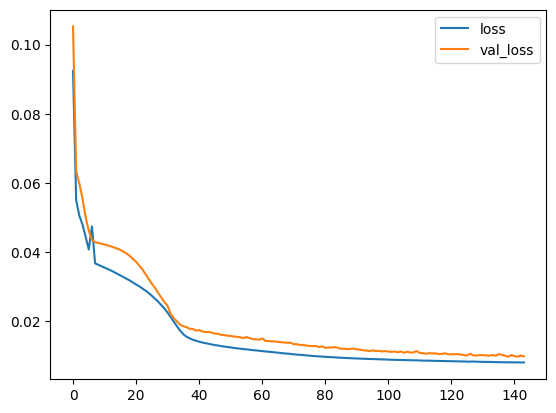

In [25]:
trained2 = model2.fit(trainX2, trainy2, validation_split=0.2, batch_size=64, epochs=300, callbacks = [early_stopping])
pd.DataFrame.from_dict(trained2.history).plot()

In [26]:
loss2 = model2.evaluate(testX2, testy2)
print(f"Test loss: {loss2}")

558/558 [==============================] - 1s 1ms/step - loss: 0.0091
Test loss: 0.009067568928003311


In [27]:
result2 = model2.predict(testX2)
result2

558/558 [==============================] - 1s 1ms/step


array([[0.04593246],
       [0.04074805],
       [0.03708269],
       ...,
       [0.01332316],
       [0.01908639],
       [0.02662056]], dtype=float32)

In [28]:
result2 = np.maximum(0, result2)
result2

array([[0.04593246],
       [0.04074805],
       [0.03708269],
       ...,
       [0.01332316],
       [0.01908639],
       [0.02662056]], dtype=float32)

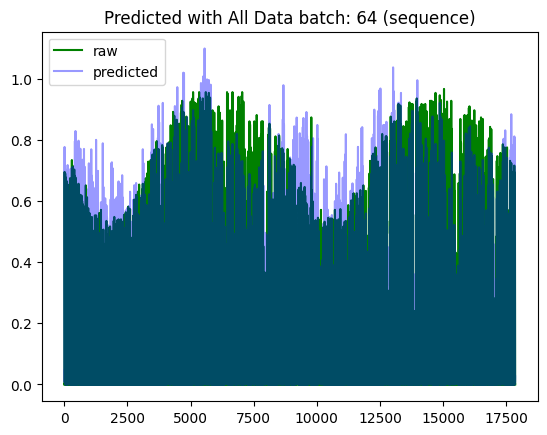

In [29]:
plt.title("Predicted with All Data batch: 64 (sequence)")
plt.plot(testy2, c="g", label="raw")
plt.plot(result2, c="b", alpha=.4, label="predicted")
plt.legend(loc="best")
plt.show()

In [30]:
error2 = mean_squared_error(testy2, result2)
print("MSE: {}, RMSE: {}".format(error2, np.sqrt(error2)))

MSE: 0.008569436041957371, RMSE: 0.09257124846277796


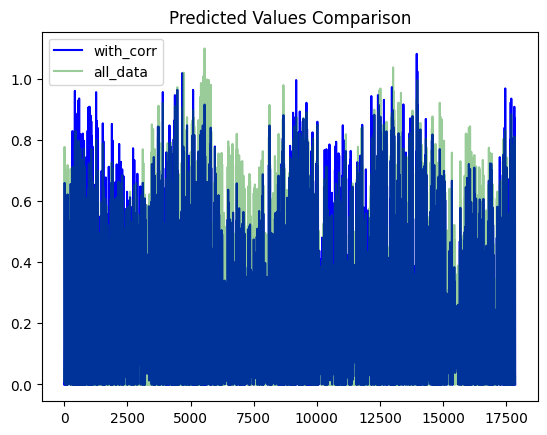

In [31]:
import matplotlib.pyplot as plt

plt.title("Predicted Values Comparison")
plt.plot( predicted1, c="b", label="with_corr")
plt.plot(result2,c="g", label="all_data", alpha=.4)
plt.xticks()
plt.legend(loc="best")
plt.show()